# Viterbi Algorithm

## Load Dependences

In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.animation as animation
import IPython.display as ipd
from environment import *

## Load Maze 1

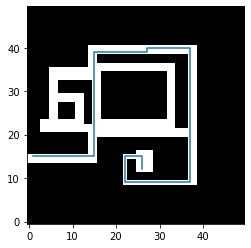

In [2]:
## Step 1: Create the world and devise robot motion
# Load in a particular environment
env = Environment("Maze1.png")
# Devise a path through that environment that passes through 3 locations
X = env.simulate_trajectory([[0, 15], [27, 40], [26, 12]])
# Plot the environment with the path superimposed
plt.figure()
env.plot()
plt.plot(X[:, 0], X[:, 1])
 
## Step 2: Simulate scans at each position
# How many angles to sample in the range scanner
res = 50
# The noise of the scanner (start with low noise to make the problem easier)
alpha = 4
# Make this repeatably pseudorandom by seeding so that the numbers you get match up with mine
np.random.seed(0) 

## Load Maze 2

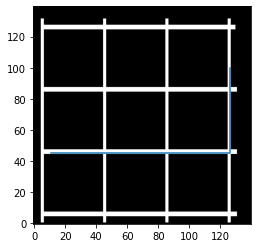

In [87]:
env = Environment("Maze2.png")
res = 50
X = env.simulate_trajectory([[10, 45], [120, 45], [126, 100]])
plt.figure()
env.plot()
plt.plot(X[:, 0], X[:, 1])

## Step 2: Simulate scans at each position
# How many angles to sample in the range scanner
res = 50
# The noise of the scanner (start with low noise to make the problem easier)
alpha = 4
# Make this repeatably pseudorandom by seeding so that the numbers you get match up with mine
np.random.seed(0) 

## Load Maze 3

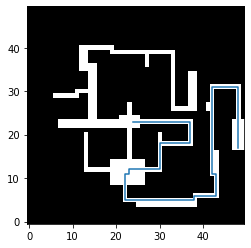

In [3]:
env = Environment("Maze3.png")
res = 50
X = env.simulate_trajectory([[23,23], [37, 20], [23, 11], [42,15], [48,17]])
plt.figure()
env.plot()
plt.plot(X[:, 0], X[:, 1])

alpha = 4
np.random.seed(0)

## Step 2: Simulate scans at each position
# How many angles to sample in the range scanner
res = 50
# The noise of the scanner (start with low noise to make the problem easier)
alpha = 4
# Make this repeatably pseudorandom by seeding so that the numbers you get match up with mine
np.random.seed(0) 

## Get Log Measurement Probability

In [10]:
def get_log_prob(exp, obs, alpha, gamma=0.1):
    """
    exp: ndarray(N)
        Ground truth scan
    obs: ndarray(N)
        Measured scan
    alpha: float
        Disparity
    """
    prod = alpha*exp + gamma
    res = -np.sum(np.log(np.sqrt(2*np.pi)*prod)) 
    res -= np.sum((exp-obs)**2 / (2*(prod**2)))
    return res

## Load Scans

In [5]:
alpha = 4
observed_scans = []
for i in range(X.shape[0]):
    observed_scans.append(env.get_range_scan(X[i, :], res, alpha))
state_scans = env.get_state_scans(res)

## Process Data Using Viterbi Algorithm

In [11]:
K = len(state_scans) # Number of states
T = X.shape[0] # Number of timesteps
alpha = 4

# Step 1: Initialize 2D TxK array for log probabilities of states and another for state index pointers
L = np.zeros(shape=(T, K), dtype=float)
B = np.zeros(shape=(T, K), dtype=float)

# Step 2: Populate first rows of B and K since formula describes first term as independent from rest of equation
for k in range(K):
    L[0, k] = -np.log(K) + get_log_prob(state_scans[k], observed_scans[0], alpha)
B[0, :] = -1

# Step 3: Update rows representing timestep T based on measurement, transition, and prior probabilities
for i in range(1, T):
    for j in range(K):

        max_j = env.neighbors[j][0]
        for l in env.neighbors[j]:
            if L[i-1, l] > L[i-1, max_j]:
                max_j = l
                
        L[i, j] = get_log_prob(state_scans[j], observed_scans[i], alpha) + L[i-1, max_j] - np.log(len(env.neighbors[max_j]))
        B[i, j] = max_j

# Step 4: Backtrace to find optimal path with reg
state = int(np.argmax(L[-1,:]))
states = list()
n = T - 1
while n > 0:
    states.append(state)
    state = int(B[n][state])
    n += -1
states.reverse()

## Plot Estimated Path

Text(0.5, 1.0, 'Estimated Trajectory, $\\alpha=4.000$')

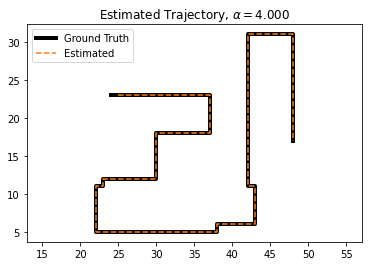

In [12]:
states = np.array(states, dtype=int)
Y = env.X[states, :]
plt.figure()
plt.plot(X[:, 0], X[:, 1], 'k', linewidth=4)
plt.plot(Y[:, 0], Y[:, 1], 'C1', linestyle='--')
plt.legend(["Ground Truth", "Estimated"])
plt.axis("equal")
plt.title("Estimated Trajectory, $\\alpha={:.3f}$".format(alpha))